In [27]:
import qml
import ase
from ase.visualize import view
import numpy as np
from qml.representations import generate_fchl_acsf
from qml.kernels import get_atomic_local_kernel
import matplotlib.pyplot as plt

In [15]:
c = qml.data.compound.Compound('../../dsgdb9nsd_050720.xyz')

In [94]:
def distance_sites(repA, repB, siteA, siteB, ZA, ZB):
    sigma = 1 # empirical
    sliceA = np.array([repA])[:,siteA:siteA+1,:]
    sliceB = np.array([repB])[:,siteB:siteB+1,:]
    
    inv_2sigma2 = -1.0 / (2 * sigma**2)
    inv_sigma2 = -1.0 / (sigma**2)
    
    q = get_atomic_local_kernel(sliceA, sliceB, np.array([ZA[siteA:siteA+1]]), np.array([ZB[siteB:siteB+1]]), sigma)[0][0]
    
    # revert transformation
    return np.log(-q/inv_sigma2)/inv_2sigma2

def distance_bn_nb(nuclear_charges, coordinates, idx_A, idx_B):
    A = nuclear_charges.copy()
    A[[idx_A, idx_B]] = (5, 7)
    B = nuclear_charges.copy()
    B[[idx_A, idx_B]] = (7, 5)
    repA, gradA = generate_fchl_acsf(A, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    repB, gradB = generate_fchl_acsf(B, coordinates, gradients=True, pad=len(nuclear_charges), elements=range(1, 10))
    
    delta = 0.01
    
    force = np.zeros((len(nuclear_charges), 3))
    basedist = distance_sites(repA, repB, idx_A, idx_B, A, B)
    for atomidx in range(len(nuclear_charges)):
        for dimension in range(3):
            repAprime = repA + delta * gradA[:, : , atomidx, dimension]
            repBprime = repB + delta * gradB[:, : , atomidx, dimension]
            graddist = distance_sites(repAprime, repBprime, idx_A, idx_B, A, B)
            dist = (graddist - basedist) / delta
            force[atomidx, dimension] = dist
    
    return basedist, force

%timeit distance_bn_nb(c.nuclear_charges, c.coordinates, 0, 11)

200 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
import ase.calculators
class GapCalc(ase.calculators.calculator.Calculator):
    implemented_properties = 'energy forces'.split()
    
    def get_potential_energy(self, atoms=None, force_consistent=False):
        ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        return ds

    def get_forces(self, atoms=None):
        ds, gradds = distance_bn_nb(c.nuclear_charges, atoms.get_positions(), 4, 2)
        return -gradds

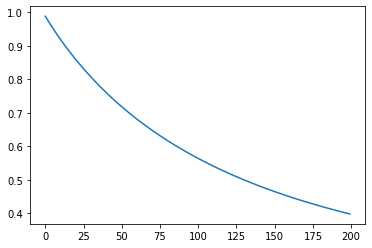

In [35]:
def do_optimisation(c, idx_A, idx_B):
    stepsize = 0.001
    maxstep = 200
    
    hist_ds = []
    coordinates = c.coordinates.copy()
    while len(hist_ds) < maxstep:
        ds, gradds = distance_bn_nb(c.nuclear_charges, coordinates, idx_A, idx_B)
        hist_ds.append(ds)
        coordinates -= stepsize*gradds
        #print ('step')
    
    plt.plot(hist_ds)
    return coordinates
cprime = do_optimisation(c, 2, 5)

In [90]:
atm = ase.Atoms(numbers=c.nuclear_charges, positions=c.coordinates, calculator=GapCalc())

In [91]:
from ase.optimize.sciopt import SciPyFminCG
dyn = LBFGS(atm, trajectory='opt.traj', use_line_search=True,)
dyn.run(fmax=0.25)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 17:43:54        0.206552*       0.5755
LBFGS:    1 17:43:56        0.199822*       0.3252
LBFGS:    2 17:43:58        0.163667*       0.9065
LBFGS:    3 17:44:01        0.129525*       0.5020
LBFGS:    4 17:44:03        0.110884*       0.5359
LBFGS:    5 17:44:05        0.104566*       0.3213
LBFGS:    6 17:44:09        0.101662*       0.3752
LBFGS:    7 17:44:11        0.098665*       0.2799
LBFGS:    8 17:44:23        0.097246*       0.2020


True

In [92]:
atm.get_positions() - c.coordinates

array([[-0.04522262,  0.07686843,  0.00817217],
       [-0.07386615,  0.02687624, -0.00367231],
       [ 0.0405141 , -0.09835865,  0.02191235],
       [-0.02334856, -0.05630805, -0.02133442],
       [ 0.08806909, -0.15149021, -0.02825447],
       [ 0.02792305, -0.05499782,  0.00704322],
       [-0.03935195, -0.06313441, -0.02112681],
       [-0.00269993, -0.000416  , -0.00056905],
       [-0.00372536, -0.00184263,  0.00049143],
       [ 0.00735586, -0.17116298, -0.01421808],
       [-0.06542806, -0.05166629, -0.03970458],
       [ 0.04593963,  0.05804877, -0.03470613],
       [ 0.03231041, -0.1061683 , -0.05847673],
       [ 0.0813798 ,  0.09403571, -0.06747128],
       [-0.12612882,  0.12488949, -0.10119161],
       [-0.22187103,  0.01581493,  0.00190436],
       [-0.00703924,  0.00762703,  0.00614766]])

In [93]:
view(atm, viewer='x3d')